## Contents
* [1. Baseline & Improved Models](#1.-Baseline-&-Improved-Models)
* [2. Read & Clean Data](#2.-Read-&-Clean-Data)
* [3. Baseline Model](#3.-Baseline-Model)
* [4. Improved Model 1](#4.-Improved-Model-1)

---
## 1. Baseline & Improved Models
---
To develop:
- Baseline model: an ARIMA model on dengue data
- Improved model 1: ARIMAX model on dengue data, using weather, google search trends, and COVID-19 circuit breaker phases to model human freedom (engineered feature to model disease vector density)
- Improved model 2: ARIMAX model on weekly data, using circuit breaker phases

|            | Baseline                          | Improved 1<br>                  | Improved 2                                                                                                                                             |
|------------------|-----------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| Model            | ARIMA                             | ARIMAX                      | ARIMAX                                                                                                                                               |
| Training data             | - 2013 - 2021 MONTHLY dengue data | - 2013 - 2021 MONTHLY dengue data<br>- Weather<br>- Google trends<br>- Circuit breaker phases | -2013-2021 WEEKLY dengue data  <br> -Circuit breaker phases
| Testing data | year of 2022               | year of 2022                                                                                                                                                       | year of 2022

---
## 2. Read & Clean Data
---

In [1]:
!pip install openpyxl

In [2]:
!pip install pmdarima

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_percentage_error # metric that's used to evaluate the performance of a time series model
import pmdarima as pm
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from pmdarima.arima import ADFTest
import os

### Reading csvs for dengue, weather and google_trends

In [4]:
dengue = pd.read_csv('data/input/Dengue_monthly.csv')
weather = pd.read_csv('data/input/weather_csv.csv')
google_trends = pd.read_csv('data/output/googletrends_clean.csv')

In [5]:
# loading data
weekly_dengue = pd.read_csv('data/input/Dengue_weekly.csv')

---
## 3. Baseline Model
---

We first start by using dengue by itself without any Exogenous features.<br>

In [6]:
#set year_month as datetime 
dengue['Year_Month'] = pd.to_datetime(dengue['Year_Month'], format='%Y.%m.%d')

We decided to train our data only from 2013 onwards as our Exogenous features from weather data were only from 2013 onwards.


In [7]:
#set year_month as index
dengue.set_index('Year_Month', inplace=True)

In [8]:
dengue = dengue.loc[dengue.index >= '2013']

In [9]:
#split it to 90 :10 split 
y_train, y_test = train_test_split(dengue['Dengue'], test_size=.1, shuffle=False)

In [10]:
arima_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           # the commented parameters below will be used in the next lesson (advanced time series)
                           # start_P=0, max_P=10,
                           # D=None,
                           # start_Q=0, max_Q=10,
                           # m=12, # For monthly data since the pattern repeats every 12 months
                           # seasonal=True,
                           trace=True, # Print values in console for each fit in the grid search
                           random=True, # to not perform an exhaustive search & set an internal stop (refer doc)
                           random_state=20, # repeatability of steps in the same order
                           n_fits=50 # max no. of ARIMA models fits, the algorithm MUST stop at the end of 50 fits
                          )

arima_model.fit(y_train) # only fit on the one column that we have, y_train

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1832.213, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1704.157, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1748.598, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1907.878, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1696.900, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1698.882, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1698.895, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1698.511, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1700.889, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1703.504, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.248 seconds


AutoARIMA(max_p=10, max_q=10, n_fits=50, random=True, random_state=20,
          start_p=0, start_q=0, trace=True)

In [11]:
y_pred = arima_model.predict(n_periods = len(y_test)) # we want as many future predictions as there are in y_test


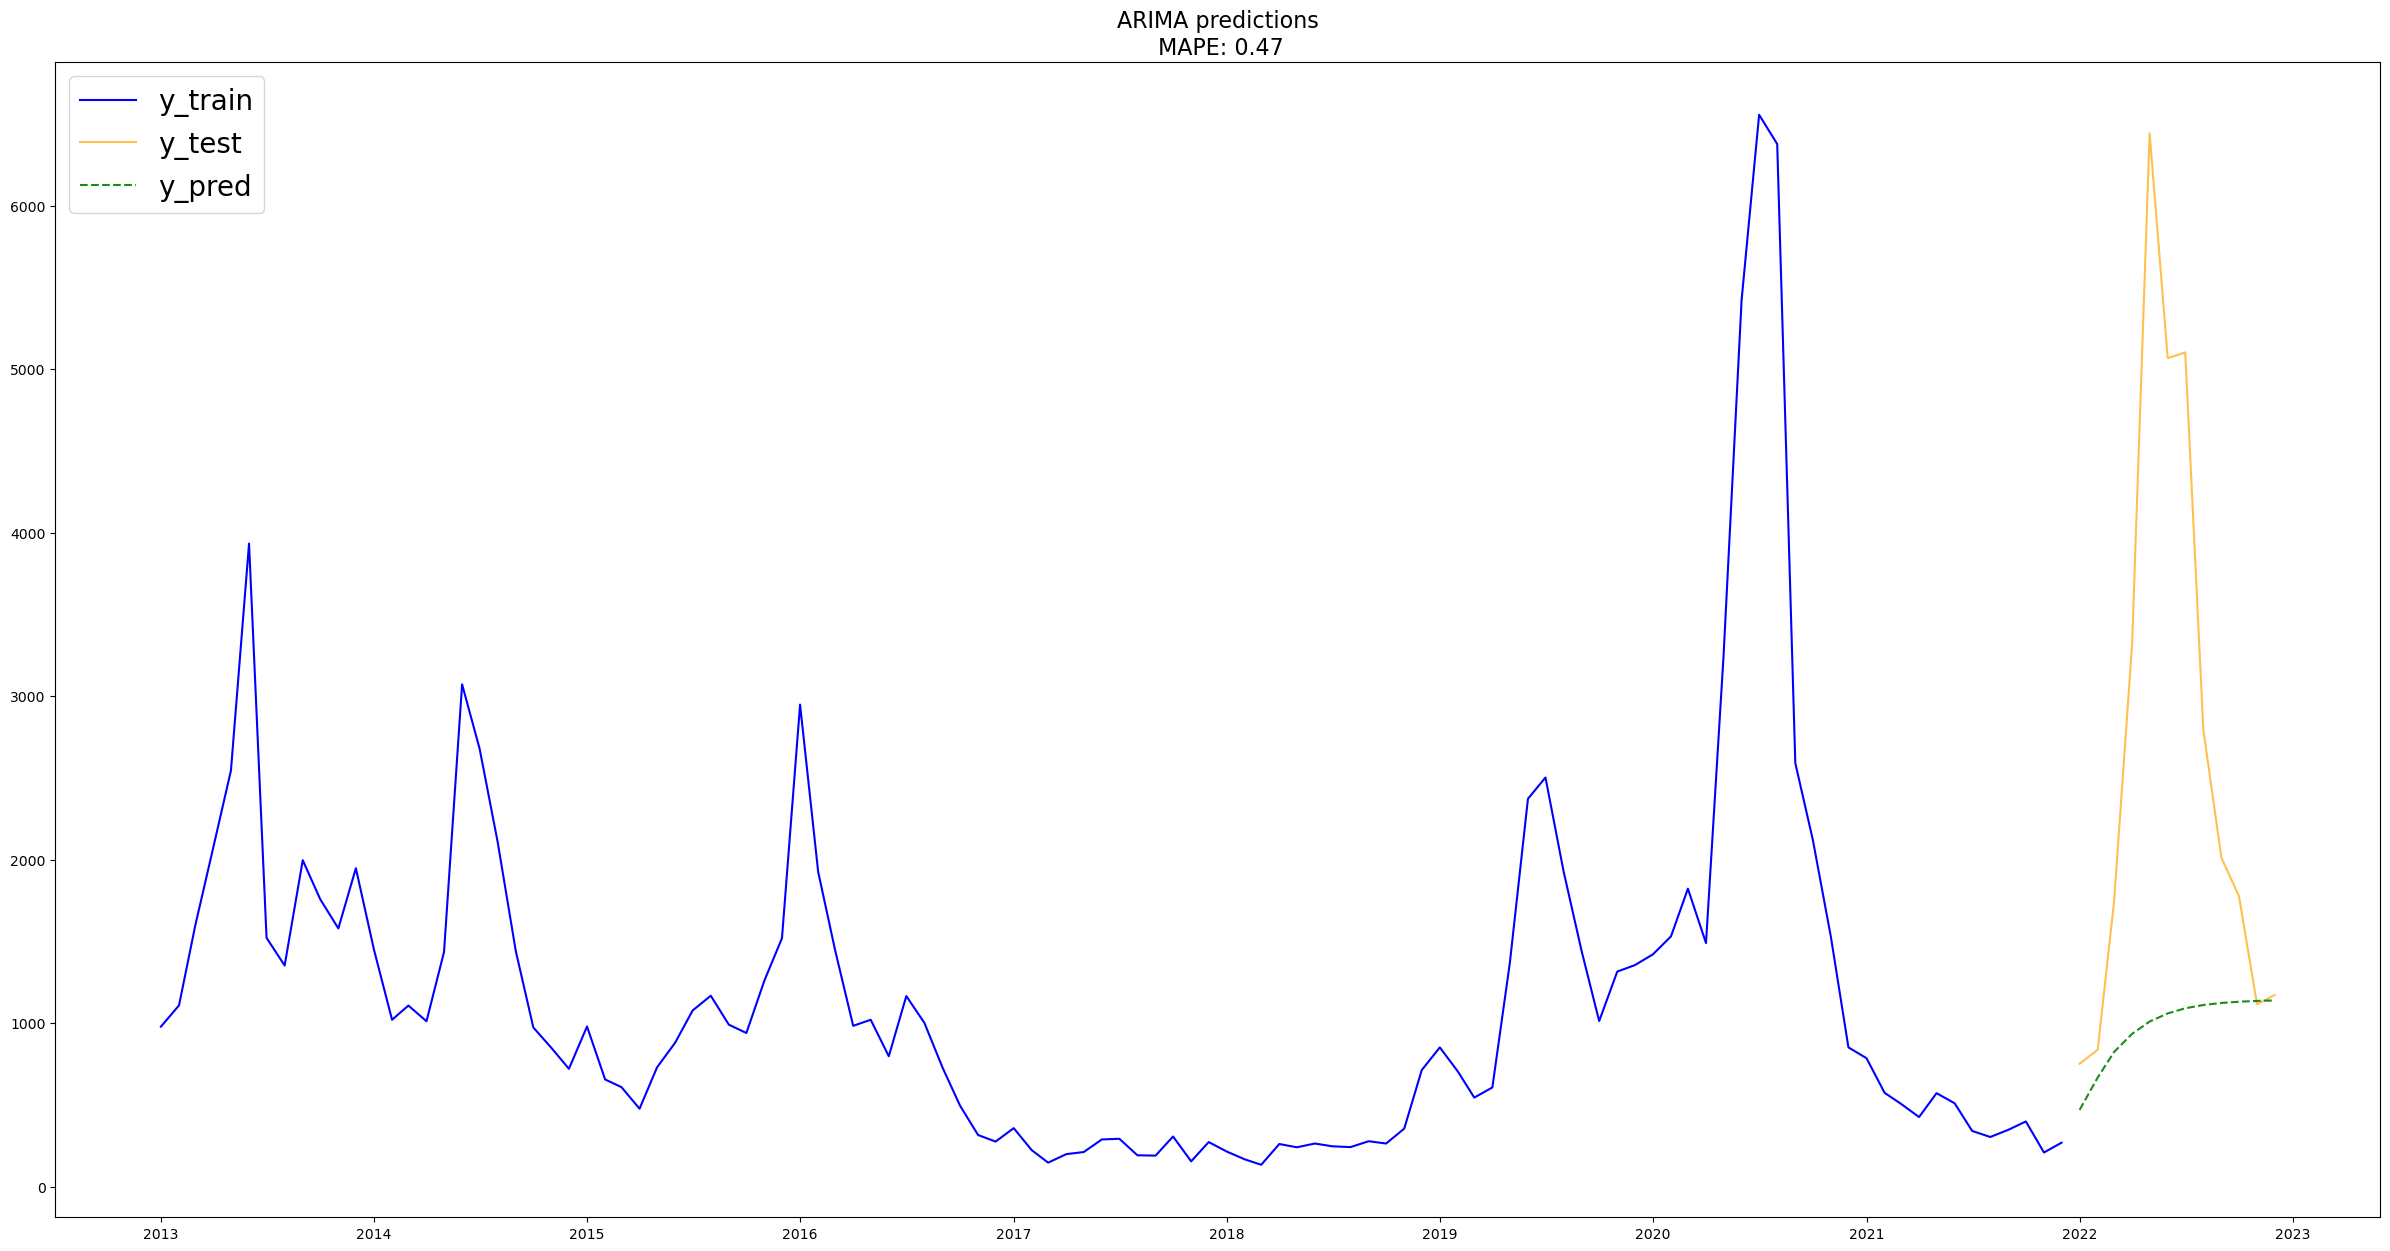

In [12]:
# Plot predictions to compare vs y_test.
plt.figure(figsize=(30,15))

# Plot training data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
plt.plot(y_train, color='blue', label='y_train')

# Plot testing data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)

# Plot predicted test values. no index in y_pred as shown above, need to explicitly pass to compare for same timeframe as y_test
plt.plot(y_test.index, y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')

plt.title(label = 'ARIMA predictions', fontsize=16)
plt.legend(fontsize = 20, loc = 'upper left');
mape = mean_absolute_percentage_error(y_test, y_pred)

plt.title(label = f'ARIMA predictions\n MAPE: {mape:.2f}', fontsize=16) #\n is just for new line to print MAPE 1 line after header 'Sales Predictions', while .2f rounds MAPE to 2 decimals
plt.legend(fontsize = 20, loc = 'upper left'); # for legend to be displayed in our plot

---
## 4. Improved Model 1
---

### setting google_trends as the index as well as formatting the date

In [13]:
google_trends['date'] = pd.to_datetime(google_trends['date'],format = '%Y.%m.%d')

In [14]:
google_trends.set_index('date',inplace=True)

In [15]:
google_trends.sort_index(inplace=True)

### join weather, google_trends and dengue

In [16]:
weather['Date'] = pd.to_datetime(weather['Date'],format = '%Y.%m.%d')

In [17]:
weather.set_index('Date',inplace=True)

In [18]:
weather.sort_index(inplace=True)

In [19]:
dengue_weather_google = weather.join([dengue,google_trends])

In [20]:
dengue_weather_google_2 = dengue_weather_google.copy()

### Using the features of dengue_weather_google_2 make feature called "human_restrictions" 
1: Pre-COVID (< 31 Dec 2019 and > 8 May 2021)

2: Phase 3 reopening (28 December 2020 - 8 May 2021 OR 1 Jan 2020 - 6 April 2020)

3: Phase 1+2 reopening (2 June 2020 - 27 December 2020)

4: Circuit breaker period (7 April 2020 – 1 June 2020) 


In [21]:
dengue_weather_google_2.loc[(dengue_weather_google_2.index < '2019-12-31') | (dengue_weather_google_2.index > '2021-05-08'), 'human_restrictions'] = 1
dengue_weather_google_2.loc[((dengue_weather_google_2.index >= '2020-12-28') & (dengue_weather_google_2.index <= '2021-05-08')) | ((dengue_weather_google_2.index>= '2020-01-01') & (dengue_weather_google_2.index<= '2020-04-06')), 'human_restrictions'] = 2
dengue_weather_google_2.loc[(dengue_weather_google_2.index >= '2020-06-02') & (dengue_weather_google_2.index <= '2020-12-27'), 'human_restrictions'] = 3
dengue_weather_google_2.loc[(dengue_weather_google_2.index >= '2020-04-07') & (dengue_weather_google_2.index <= '2020-06-01'), 'human_restrictions'] = 4

In [22]:
dengue_weather_google_2.drop(columns=['DHF', 'dhf'])

,mean_temp,no_rain_day,mean_humidity,mean_sunshine_hour,normal_dengue,dengue_total,Dengue,dengue symptoms,dengue fever,dengue how,dengue mosquito,mosquito bite,human_restrictions
Date,,,,,,,,,,,,,
2013-01-01,27.1,15,82.1,6.0,979,984,979,11,20,2,0,4,1.0
2013-02-01,26.5,22,86.9,4.0,1109,1114,1109,20,35,3,6,4,1.0
2013-03-01,28.3,10,80.4,7.5,1600,1610,1600,13,26,2,4,6,1.0
2013-04-01,28.2,19,82.7,5.2,2079,2086,2079,40,50,4,14,7,1.0
2013-05-01,28.2,17,83.1,5.4,2546,2555,2546,47,54,5,10,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,28.1,15,77.4,5.5,2796,2801,2796,31,14,6,4,5,1.0
2022-09-01,27.9,14,76.9,3.8,2012,2013,2012,25,14,5,5,5,1.0
2022-10-01,27.6,27,78.7,3.5,1778,1780,1778,21,10,4,3,6,1.0


### Functions for use

x_y seperates our dengue from our Exogenous features.

In [23]:
def x_y(z):
    y = z['Dengue']
    x = z.drop(columns = 'Dengue')
    return y,x

In [24]:
dengue_weather_google_2

,mean_temp,no_rain_day,mean_humidity,mean_sunshine_hour,normal_dengue,dhf,dengue_total,Dengue,DHF,dengue symptoms,dengue fever,dengue how,dengue mosquito,mosquito bite,human_restrictions
Date,,,,,,,,,,,,,,,
2013-01-01,27.1,15,82.1,6.0,979,5,984,979,5,11,20,2,0,4,1.0
2013-02-01,26.5,22,86.9,4.0,1109,5,1114,1109,5,20,35,3,6,4,1.0
2013-03-01,28.3,10,80.4,7.5,1600,10,1610,1600,10,13,26,2,4,6,1.0
2013-04-01,28.2,19,82.7,5.2,2079,7,2086,2079,7,40,50,4,14,7,1.0
2013-05-01,28.2,17,83.1,5.4,2546,9,2555,2546,9,47,54,5,10,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,28.1,15,77.4,5.5,2796,5,2801,2796,5,31,14,6,4,5,1.0
2022-09-01,27.9,14,76.9,3.8,2012,1,2013,2012,1,25,14,5,5,5,1.0
2022-10-01,27.6,27,78.7,3.5,1778,2,1780,1778,2,21,10,4,3,6,1.0


We decided to shift the data down a month, as it was assumed that Dengue would only manifest a month after ideal conditions (inclusive of the life cycle and symptoms arising in patients).

In [25]:
#after shift joined back to dengue
shifted_dengue_weather_google_2 = dengue_weather_google_2.drop(columns='Dengue').shift().join(dengue_weather_google['Dengue'])

In [26]:
shifted_dengue_weather_google_2.dropna(inplace=True)
train = shifted_dengue_weather_google_2[:'2021']
test = shifted_dengue_weather_google_2['2022':]

In [27]:
def plot_forecast(y_train, y_test, z, X_test=None):
    # Generate len(y_test) number of predictions
    y_pred = z.predict(n_periods = len(y_test), X=X_test) # we want as many future data point predictions as there are in y_test
    print(y_pred)
    # Plot data.
    plt.figure(figsize=(30,15))

    # Plot training data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)

    # Plot predicted test values. as shared previously, there are no index in y_pred 
    # so, we need to explicitly pass the `x-axis` (dates) to compare for same timeframe as y_test and access y_pred vs actual y_test
    # we can use y_test.index to get the index of y_test as confirmed earlier in y_test.head()
    plt.plot(y_test.index, y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    # Find the MAPE (mean abs percentage error) of the predictions
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    mape = mean_absolute_percentage_error(y_test, y_pred) # like all sklearn metrics we've used, pass y_actual, y_pred

    plt.title(label = f'ARIMA predictions\n MAPE: {mape:.2f}', fontsize=16) #\n is just for new line to print MAPE 1 line after header 'Sales Predictions', while .2f rounds MAPE to 2 decimals
    plt.legend(fontsize = 20, loc = 'upper left');

In [28]:
train_y, train_x = x_y(train)
test_y, test_x = x_y(test)

In [29]:
arima_model_human = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           start_P=0, max_P=10,
                           D=None,
                           start_Q=0, max_Q=10, 
                           trace=True, # Print values for each fit in the grid search
                           random=True,
                           random_state=20,
                           n_fits=300
                          )

arima_model_human.fit(train_y, train_x)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1699.868, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1692.053, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1697.184, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1697.872, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1692.590, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1693.187, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1694.771, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1683.397, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1690.336, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1691.187, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1694.370, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1692.797, Time=0.28 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.820 seconds


AutoARIMA(max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=300, random=True,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

All p values are less than 0.05 meaning the direction relationship between our features and dengue were particularly strong.

In [30]:
arima_model_human.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -825.699
Date:                Fri, 10 Feb 2023   AIC                           1683.397
Time:                        18:29:34   BIC                           1726.162
Sample:                    02-01-2013   HQIC                          1700.734
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
mean_temp             -8.1744    104.559     -0.078      0.938    -213.107     196.758
no_rain_day           20.5600     28.528      0.721      0.471     -35.353      76.473
mean_humidity          7.0583     33.430      0.211      0.833     -58.463      72.580
mean_sunshine_hour   -11.7153    113.396     -0.103      0.918    -233.967     210.536
normal_dengue         -2.5204      5.942     -0.424      0.671     -14.167       9.126
dhf                    5.3209     11.853      0.449      0.653     -17.911      28.552
dengue_total           2.7873      5.915      0.471      0.638      -8.807      14.381
DHF                    5.3209     11.853      0.449      0.653     -17.911      28.552
dengue symptoms       19.1274     28.224      0.678      0.498     -36.190      74.445
dengue fever         -35.9730     26.538     -1.356      0.175     -87.987      16.041
dengue how             0.9143     82.318      0.011      0.991    -160.426     162.255
dengue mosquito       50.2818     49.839      1.009      0.313     -47.400     147.964
mosquito bite         18.5861     37.441      0.496      0.620     -54.797      91.969
human_restrictions   246.8567    210.361      1.173      0.241    -165.442     659.156
ar.L1                  0.7586      0.202      3.757      0.000       0.363       1.154
sigma2              3.249e+05   5.04e+04      6.440      0.000    2.26e+05    4.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               150.81
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.07
Prob(H) (two-sided):                  0.61   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+23. Standard errors may be unstable.
"""

2022-01-01     451.780792
2022-02-01     797.070665
2022-03-01     792.598445
2022-04-01    1294.529786
2022-05-01    2007.191649
2022-06-01    3002.686608
2022-07-01    2872.061860
2022-08-01    2824.721147
2022-09-01    1937.107780
2022-10-01    1623.737983
2022-11-01    1858.427959
2022-12-01    1656.688364
Freq: MS, dtype: float64


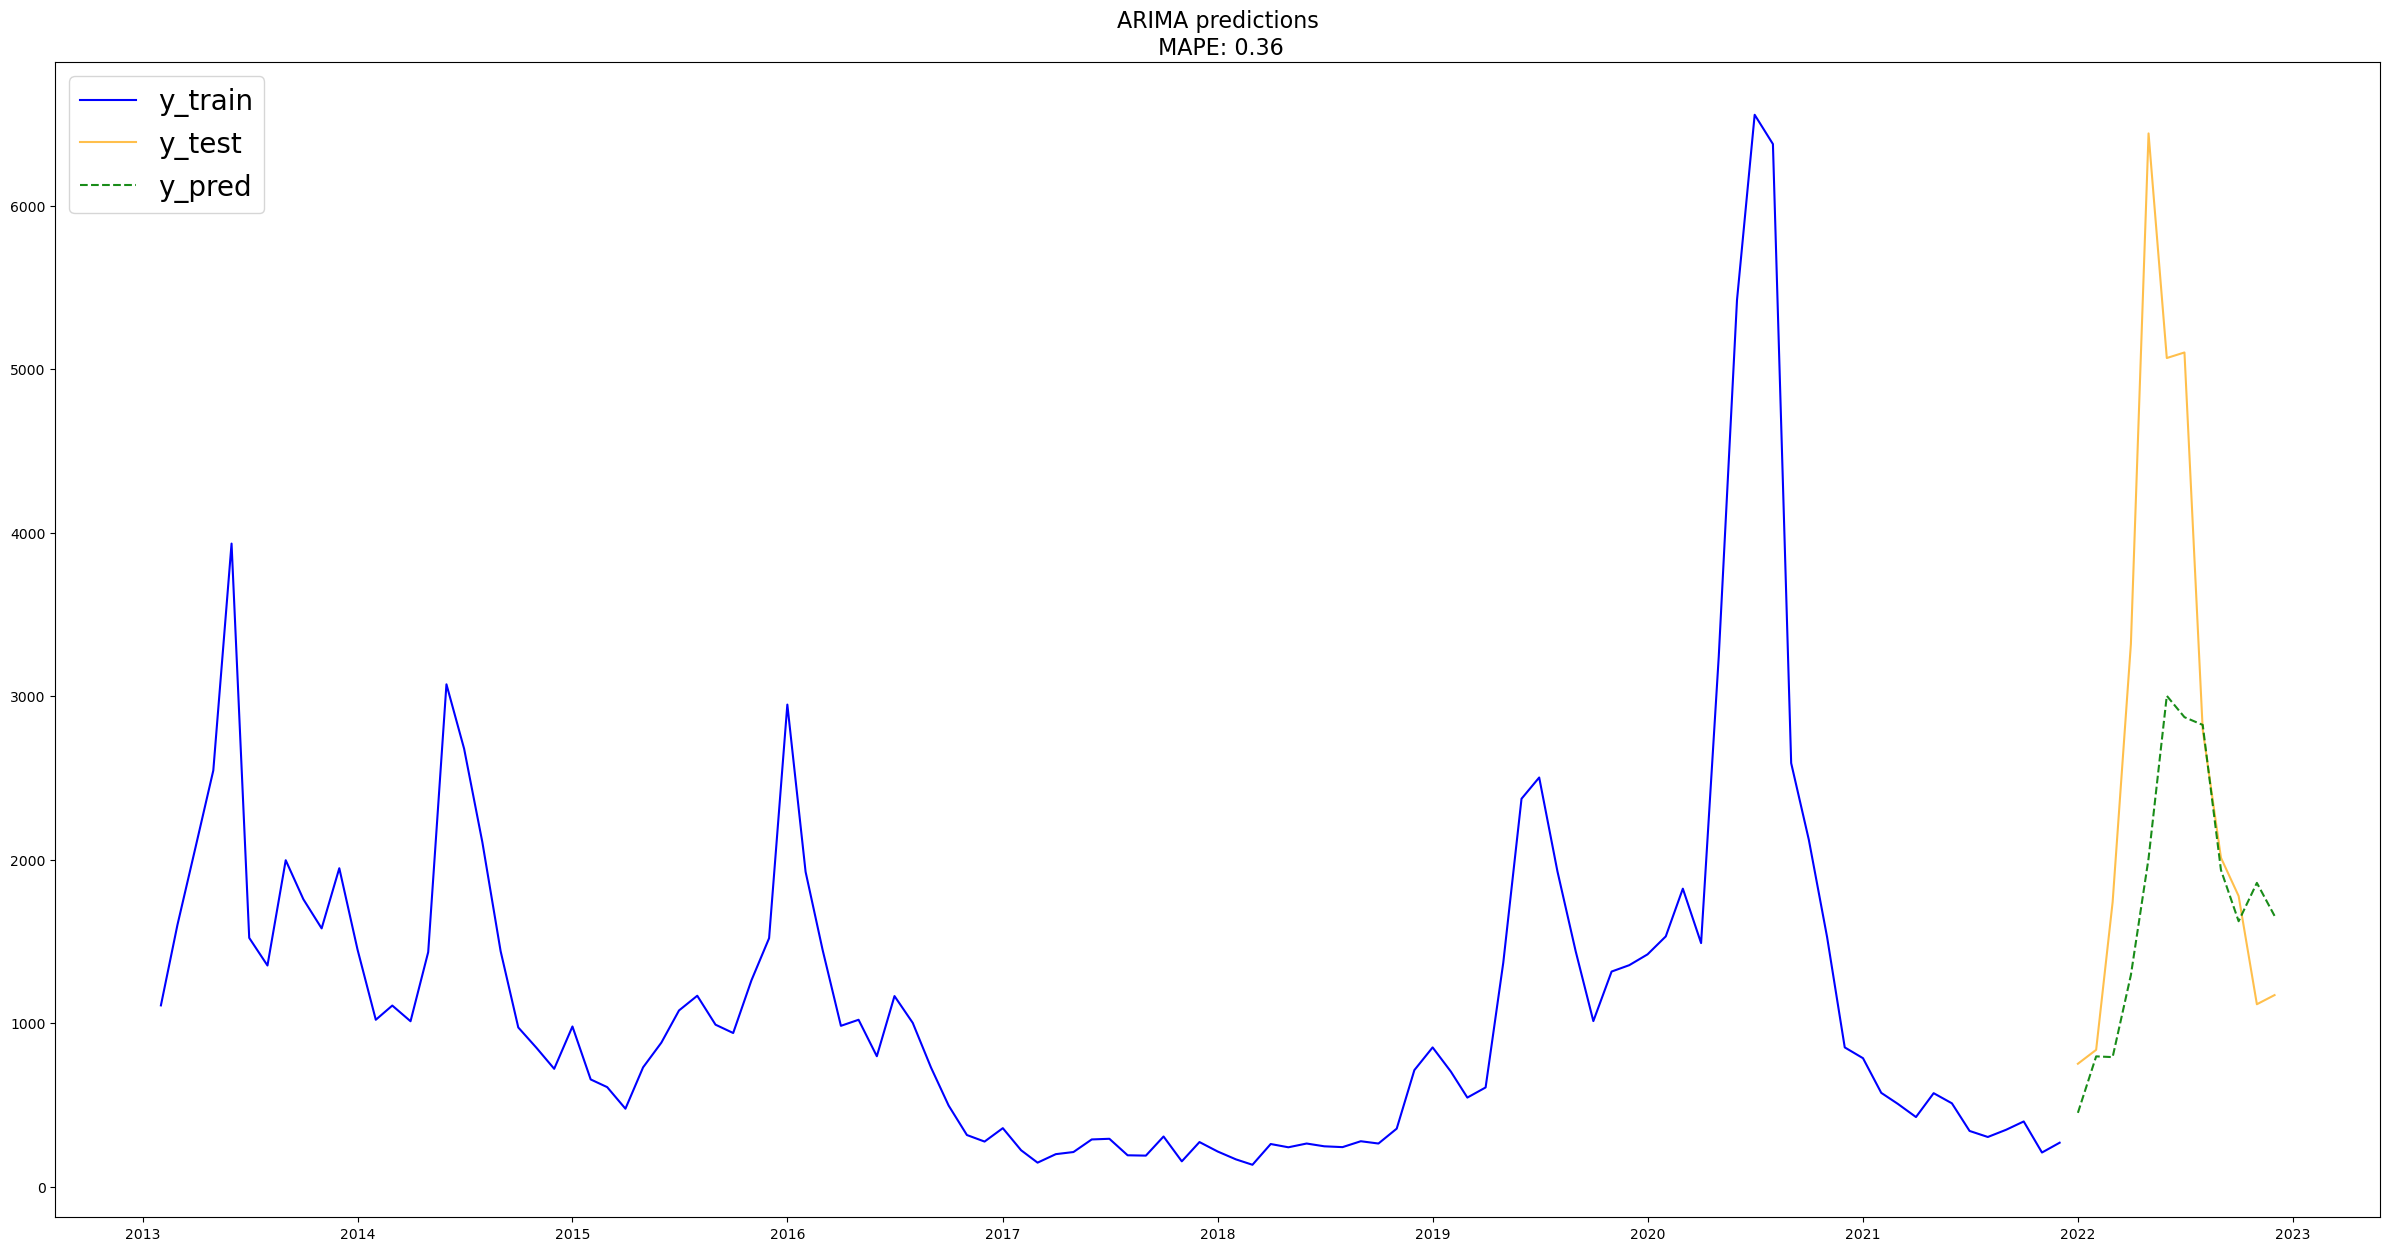

In [31]:
plot_forecast(train_y, test_y, arima_model_human, test_x)

## Dengue weekly

Something to note is that we did not have access to weekly data for weather and google trends thus our follow up analysis was with only our "human restrictions" as well as the number of dengue cases.

In [32]:
# Change 'Start' col data type to the correct format
weekly_dengue['Start'] = pd.to_datetime(weekly_dengue['Start'])

In [33]:
# Extract 'Start' and 'Dengue' col only
weekly_dengue = weekly_dengue[['Start', 'Dengue']]


In [34]:
# Rename col names
weekly_dengue.rename(columns={'Start':'date', 'Dengue':'dengue'}, inplace=True)

In [35]:
# Check data types and col names
weekly_dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    574 non-null    datetime64[ns]
 1   dengue  574 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.1 KB


In [36]:
# Set index to be the date column 
weekly_dengue = weekly_dengue.set_index('date')

In [37]:
# Ascending sort on the index: 'date' from earliest to latest
weekly_dengue = weekly_dengue.sort_index()

In [38]:
weekly_dengue.loc[(weekly_dengue.index < '2019-12-31') | (weekly_dengue.index > '2021-05-08'), 'human_restrictions'] = 1
weekly_dengue.loc[((weekly_dengue.index >= '2020-12-28') & (weekly_dengue.index <= '2021-05-08')) | ((weekly_dengue.index>= '2020-01-01') & (weekly_dengue.index<= '2020-04-06')), 'human_restrictions'] = 2
weekly_dengue.loc[(weekly_dengue.index >= '2020-06-02') & (weekly_dengue.index <= '2020-12-27'), 'human_restrictions'] = 3
weekly_dengue.loc[(weekly_dengue.index >= '2020-04-07') & (weekly_dengue.index <= '2020-06-01'), 'human_restrictions'] = 4

We decided to shift the data down a month, as it was assumed that Dengue would only manifest a month after ideal conditions (inclusive of the life cycle and symptoms arising in patients).

In [39]:
#after shift joined back to dengue
weekly_dengue = weekly_dengue.drop(columns='dengue').shift(4).join(weekly_dengue['dengue'])

In [40]:
weekly_dengue.dropna(inplace=True)
train, test = train_test_split(weekly_dengue, test_size=.1, shuffle=False)  

In [41]:
def x_y_2(z):
    y = z['dengue']
    x = z.drop(columns = 'dengue')
    return y,x

In [42]:
#split out the weekly data for training and testing
train_y_w, train_x_w = x_y_2(train)
test_y_w, test_x_w = x_y_2(test)

In [43]:
# Check dataset
weekly_dengue.head()

,human_restrictions,dengue
date,,
2012-01-29,1.0,84
2012-02-05,1.0,87
2012-02-12,1.0,65
2012-02-19,1.0,50
2012-02-26,1.0,55


In [44]:
# Instantiate and fit ARIMA model
arima_model = pm.AutoARIMA(start_p=0, max_p=10,  # max 10 months
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,  # max 10 previous error
                           trace=True, # Print values in console for each fit in the grid search
                           random_state=20, # repeatability of steps in the same order
                           )

arima_model.fit(train_y_w,train_x_w) # only fit on the one column that we have, y_train2

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5588.974, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5589.564, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5590.084, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5586.975, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5566.362, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5536.033, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5544.388, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5536.646, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5535.280, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5533.291, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5551.336, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5535.067, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5544.996, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5535.097, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0]          

AutoARIMA(max_p=10, max_q=10, random_state=20, start_p=0, start_q=0, trace=True)

- The best model with Auto ARIMA is ARIMA(1,1,2)(0,0,0)[0] intercept.

In [45]:
# Print summary results
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  513
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2760.646
Date:                Fri, 10 Feb 2023   AIC                           5531.291
Time:                        18:29:39   BIC                           5552.483
Sample:                    01-29-2012   HQIC                          5539.598
                         - 11-21-2021                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
human_restrictions   -21.5796     14.374     -1.501      0.133     -49.753       6.594
ar.L1                  0.6638      0.047     14.003      0.000       0.571       0.757
ma.L1                 -0.6790      0.047    -14.341      0.000      -0.772      -0.586
ma.L2                  0.2762      0.020     13.512      0.000       0.236       0.316
sigma2              2821.1733     71.938     39.217      0.000    2680.178    2962.169
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3923.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -1.01
Prob(H) (two-sided):                  0.03   Kurtosis:                        16.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Making and Plot Predictions

2021-11-28    63.202329
2021-12-05    67.197544
2021-12-12    69.849382
2021-12-19    71.609548
2021-12-26    72.777865
2022-01-02    73.553339
2022-01-09    74.068063
2022-01-16    74.409713
2022-01-23    74.636484
2022-01-30    74.787004
2022-02-06    74.886912
2022-02-13    74.953227
2022-02-20    74.997243
2022-02-27    75.026459
2022-03-06    75.045852
2022-03-13    75.058723
2022-03-20    75.067267
2022-03-27    75.072938
2022-04-03    75.076702
2022-04-10    75.079200
2022-04-17    75.080859
2022-04-24    75.081959
2022-05-01    75.082690
2022-05-08    75.083175
2022-05-15    75.083497
2022-05-22    75.083710
2022-05-29    75.083852
2022-06-05    75.083946
2022-06-12    75.084009
2022-06-19    75.084050
2022-06-26    75.084078
2022-07-03    75.084096
2022-07-10    75.084108
2022-07-17    75.084116
2022-07-24    75.084122
2022-07-31    75.084125
2022-08-07    75.084127
2022-08-14    75.084129
2022-08-21    75.084130
2022-08-28    75.084131
2022-09-04    75.084131
2022-09-11    75

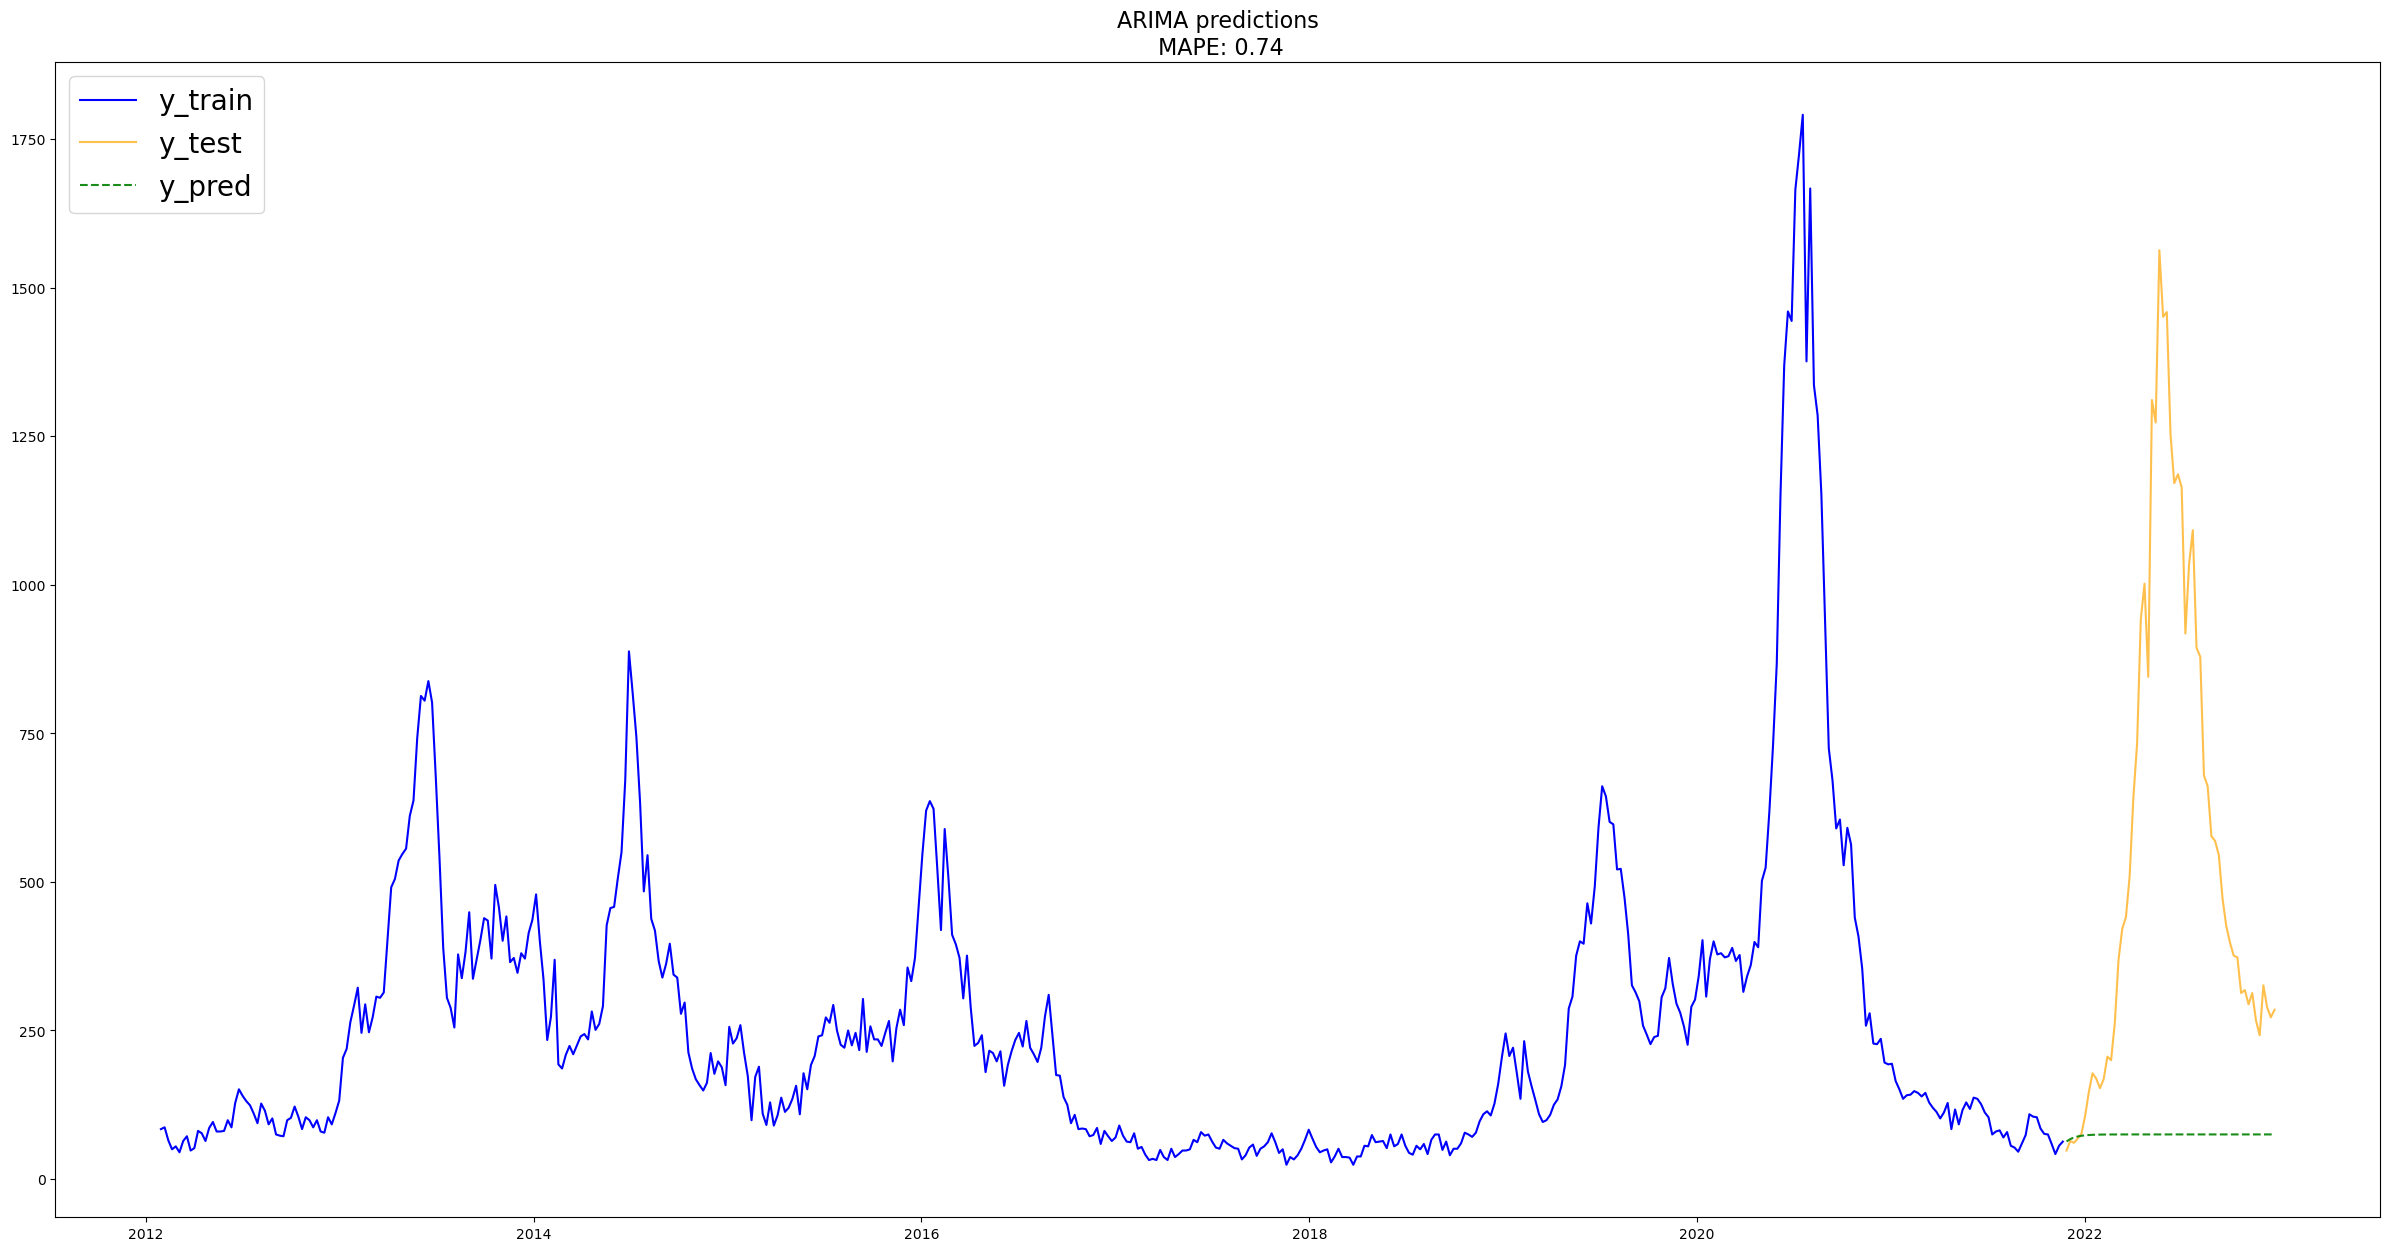

In [46]:
plot_forecast(train_y_w, test_y_w, arima_model,X_test=test_x_w)

We can see that as compared to the baseline, our model performed better with all our additional features when observing the MAPE score decreased. However, when we try and look at a weekly level, we are unable to see a similar improvement.

|            | Baseline                          | Improved 1<br>\*Best performance\*                   | Improved 2                                                                                                                                             |
|------------------|-----------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| Model            | ARIMA                             | ARIMAX                      | ARIMAX                                                                                                                                               |
| Training data             | - 2013 - 2021 MONTHLY dengue data | - 2013 - 2021 MONTHLY dengue data<br>- Weather<br>- Google trends<br>- Circuit breaker phases | -2013-2021 WEEKLY dengue data  <br> -Circuit breaker phases
| Testing data | year of 2022               | year of 2022                                                                                                                                                       | year of 2022
| MAPE score       | 0.47                              | 0.36                                                                                                                                                                  | 0.80